# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from ResNet import ResnetBuilder # ResNet.py
import json
import itertools
import gc
import glob
from IPython.display import clear_output

# 2. Data Processing

## 2.1 Load Data

In [2]:
# 元データはCSV．各列がピクセルの位置を示しており各行が個々のデータを表す．
train = pd.read_csv("./data/train.csv") # trainのみ1列目にラベル(0-9)が与えられている
test = pd.read_csv("./data/test.csv")

# 画像サイズ
img_size_x = 28
img_size_y = 28
channels = 1

# trainラベル
label_num = np.array(train.label) # 0-9
label = pd.get_dummies(label_num).values # one-hot encoding
class_names = np.unique(label_num).astype("str") # クラス名 "0"-"9"
n_classes = len(np.unique(label_num)) # クラス数　=　10

# trainからラベル列を削除
train = train.drop(labels = ["label"], axis = 1) 

## 2.2 Preprocess

In [3]:
# 平均０，分散１となるように各データを正規化
train = scale(train, axis=1)
test = scale(test, axis=1)

# 元データを入力形状(データ数*28*28*1)に変換
train = train.reshape(-1,28,28,1).astype('float32')
test = test.reshape(-1,28,28,1).astype('float32')

C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


## 2.3 Show Image Sample

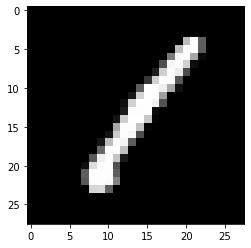

In [4]:
plt.figure()
plt.imshow(train[0,:,:,0], cmap='gray')
plt.show()

# 3. Model Summary

## 3.1 Structure

In [6]:
inputShape=(img_size_x, img_size_y, channels)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50モデル
ResNetModel.summary()
clear_session()
del ResNetModel
gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

102835

## 3.2 Result Setting

In [4]:
# modelのバージョン毎に結果保存用のフォルダを作成
model_name = "ResNet50_epoch10_batch32_ensemble" # 設定に変更があった場合ここだけ変更 ensemble
csv_dir = "./Result/"+model_name 
conf_dir = csv_dir+"/CM_result" # 混合行列画像保存用のサブフォルダ
model_dir = csv_dir+"/model_dir"

# 新規にフォルダを作成する関数．同名のフォルダがすでに存在する場合は削除して作り直す
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)
    else:
        shutil.rmtree(path)
        os.makedirs(path)
        
# 結果保存用フォルダの作成
my_makedirs(csv_dir)
my_makedirs(conf_dir)
my_makedirs(model_dir)

# 4. Evaluate Model

## 4.1 Training Setting

In [5]:
# 学習の設定
inputShape=(img_size_x, img_size_y, channels)
batch_size = 32 # 32, 64, 128, 256, 512(first), 1024, 2048など調整
n_epoch = 10 # エポック数
learning_rate = 0.001 #0.003
early_stopping_patience = 300 # 性能向上がない場合，学習を早期終了するエポック数
sp = 10 # 交差検証の分割数

# 評価指標の設定(accuracy, 各クラスのprecision, recall, fscoreとそれらの平均)
predict = np.empty([len(label), n_classes])
predict_label = np.empty([len(label), n_classes])
acc_list = np.empty([sp,1])
precision_list = np.empty([sp, n_classes])
recall_list = np.empty([sp, n_classes])
fscore_list = np.empty([sp, n_classes])
avg_precision = np.empty([sp,1])
avg_recall = np.empty([sp,1])
avg_fscore = np.empty([sp,1])

## 4.2 Training and Validation (10-fold cross validation)

### 4.2.1 Each fold iteration

Iteration No. 1

Train on 37794 samples, validate on 4206 samples
Epoch 1/10
37792/37794 [============================>.] - ETA: 0s - loss: 4.1834 - acc: 0.9572
Epoch 00001: val_loss improved from inf to 3.45220, saving model to img_classifier_model_1_ResNet50_epoch10_batch32_ensemble.h5
37794/37794 [==============================] - 70s 2ms/sample - loss: 4.1834 - acc: 0.9572 - val_loss: 3.4522 - val_acc: 0.9826
Epoch 2/10
37760/37794 [============================>.] - ETA: 0s - loss: 3.1499 - acc: 0.9881- ETA:
Epoch 00002: val_loss improved from 3.45220 to 2.91891, saving model to img_classifier_model_1_ResNet50_epoch10_batch32_ensemble.h5
37794/37794 [==============================] - 59s 2ms/sample - loss: 3.1497 - acc: 0.9881 - val_loss: 2.9189 - val_acc: 0.9879
Epoch 3/10
37760/37794 [============================>.] - ETA: 0s - loss: 2.7400 - acc: 0.9951- ETA
Epoch 00003: val_loss improved from 2.91891 to 2.62111, saving model to img_classifier_model_1_ResNet50_epoch10_batch32_en

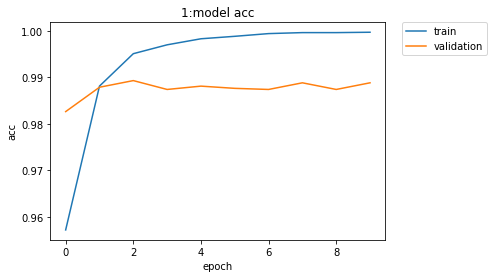

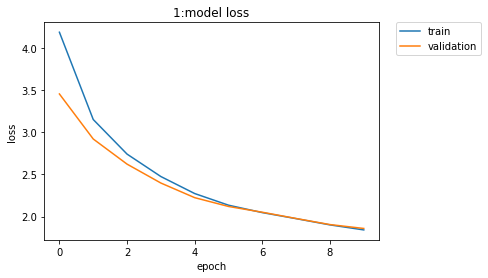

Done compiling best model.


1. Accuracy on validation data: 0.988825
Classification Report
              precision    recall  f1-score   support

           0    0.99758   0.99758   0.99758       414
           1    1.00000   0.99787   0.99893       469
           2    0.98807   0.99043   0.98925       418
           3    0.98630   0.99083   0.98856       436
           4    0.97821   0.99020   0.98417       408
           5    0.98677   0.98158   0.98417       380
           6    0.99272   0.98792   0.99031       414
           7    0.99093   0.99093   0.99093       441
           8    0.99257   0.98526   0.98890       407
           9    0.97375   0.97375   0.97375       419

   micro avg    0.98883   0.98883   0.98883      4206
   macro avg    0.98869   0.98863   0.98866      4206
weighted avg    0.98885   0.98883   0.98883      4206
 samples avg    0.98883   0.98883   0.98883      4206





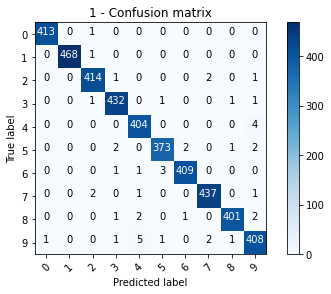

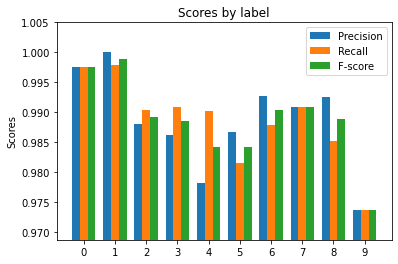

Iteration No. 2

Train on 37796 samples, validate on 4204 samples
Epoch 1/10
37760/37796 [============================>.] - ETA: 0s - loss: 4.2270 - acc: 0.9565
Epoch 00001: val_loss improved from inf to 3.51202, saving model to img_classifier_model_2_ResNet50_epoch10_batch32_ensemble.h5
37796/37796 [==============================] - 68s 2ms/sample - loss: 4.2264 - acc: 0.9565 - val_loss: 3.5120 - val_acc: 0.9831
Epoch 2/10
37760/37796 [============================>.] - ETA: 0s - loss: 3.1566 - acc: 0.9908
Epoch 00002: val_loss improved from 3.51202 to 2.90538, saving model to img_classifier_model_2_ResNet50_epoch10_batch32_ensemble.h5
37796/37796 [==============================] - 59s 2ms/sample - loss: 3.1564 - acc: 0.9908 - val_loss: 2.9054 - val_acc: 0.9829
Epoch 3/10
37792/37796 [============================>.] - ETA: 0s - loss: 2.6690 - acc: 0.9956- ETA: - ETA: 0s - loss: 2.6699 - acc: 0.9
Epoch 00003: val_loss improved from 2.90538 to 2.52481, saving model to img_classifier_mode

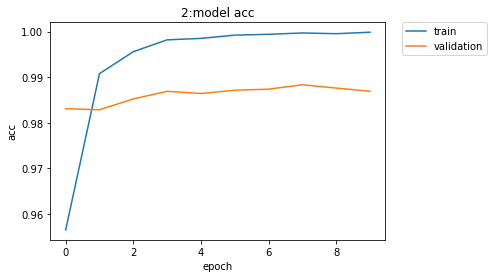

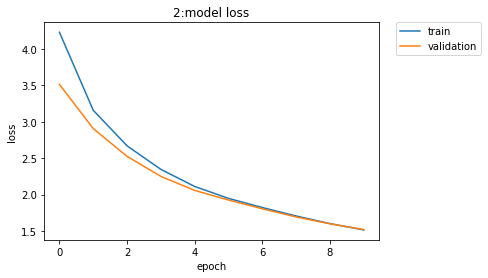

Done compiling best model.


2. Accuracy on validation data: 0.986917
Classification Report
              precision    recall  f1-score   support

           0    0.98801   0.99517   0.99158       414
           1    0.99785   0.98934   0.99358       469
           2    0.98565   0.98565   0.98565       418
           3    0.98851   0.98851   0.98851       435
           4    0.98068   0.99510   0.98783       408
           5    0.97900   0.98158   0.98029       380
           6    0.99511   0.98309   0.98906       414
           7    0.98869   0.99318   0.99093       440
           8    0.97561   0.98280   0.97919       407
           9    0.98789   0.97375   0.98077       419

   micro avg    0.98692   0.98692   0.98692      4204
   macro avg    0.98670   0.98682   0.98674      4204
weighted avg    0.98696   0.98692   0.98692      4204
 samples avg    0.98692   0.98692   0.98692      4204





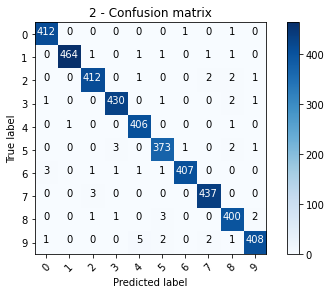

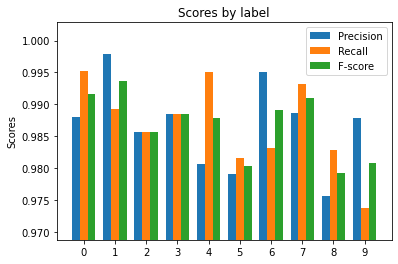

Iteration No. 3

Train on 37798 samples, validate on 4202 samples
Epoch 1/10
37792/37798 [============================>.] - ETA: 0s - loss: 4.2224 - acc: 0.9546- ETA: 3s
Epoch 00001: val_loss improved from inf to 3.50413, saving model to img_classifier_model_3_ResNet50_epoch10_batch32_ensemble.h5
37798/37798 [==============================] - 68s 2ms/sample - loss: 4.2225 - acc: 0.9545 - val_loss: 3.5041 - val_acc: 0.9814
Epoch 2/10
37760/37798 [============================>.] - ETA: 0s - loss: 3.1574 - acc: 0.9900
Epoch 00002: val_loss improved from 3.50413 to 2.90069, saving model to img_classifier_model_3_ResNet50_epoch10_batch32_ensemble.h5
37798/37798 [==============================] - 59s 2ms/sample - loss: 3.1572 - acc: 0.9900 - val_loss: 2.9007 - val_acc: 0.9857
Epoch 3/10
37792/37798 [============================>.] - ETA: 0s - loss: 2.6801 - acc: 0.9958- ETA: 0s - loss: 2.6816 - acc: 0
Epoch 00003: val_loss improved from 2.90069 to 2.53313, saving model to img_classifier_mode

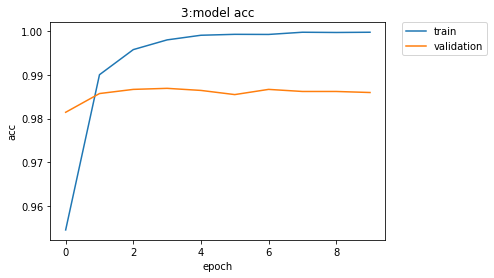

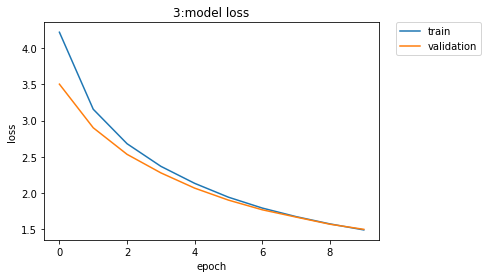

Done compiling best model.


3. Accuracy on validation data: 0.985959
Classification Report
              precision    recall  f1-score   support

           0    0.99755   0.98547   0.99147       413
           1    0.99359   0.99147   0.99253       469
           2    0.97862   0.98565   0.98212       418
           3    0.98851   0.98851   0.98851       435
           4    0.98284   0.98526   0.98405       407
           5    0.98684   0.98684   0.98684       380
           6    0.98095   0.99517   0.98801       414
           7    0.98636   0.98636   0.98636       440
           8    0.98753   0.97297   0.98020       407
           9    0.97625   0.98091   0.97857       419

   micro avg    0.98596   0.98596   0.98596      4202
   macro avg    0.98590   0.98586   0.98587      4202
weighted avg    0.98599   0.98596   0.98596      4202
 samples avg    0.98596   0.98596   0.98596      4202





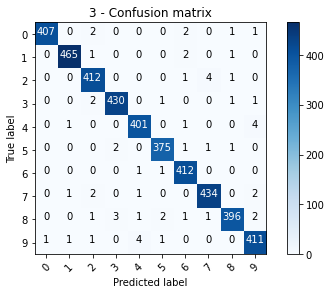

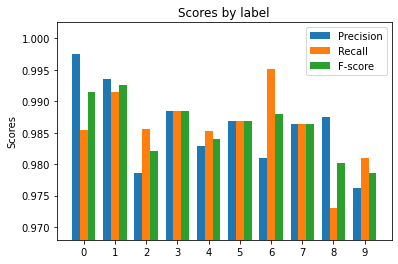

Iteration No. 4

Train on 37799 samples, validate on 4201 samples
Epoch 1/10
37792/37799 [============================>.] - ETA: 0s - loss: 4.1806 - acc: 0.9577
Epoch 00001: val_loss improved from inf to 3.45530, saving model to img_classifier_model_4_ResNet50_epoch10_batch32_ensemble.h5
37799/37799 [==============================] - 69s 2ms/sample - loss: 4.1805 - acc: 0.9578 - val_loss: 3.4553 - val_acc: 0.9819
Epoch 2/10
37760/37799 [============================>.] - ETA: 0s - loss: 3.0891 - acc: 0.9900
Epoch 00002: val_loss improved from 3.45530 to 2.82850, saving model to img_classifier_model_4_ResNet50_epoch10_batch32_ensemble.h5
37799/37799 [==============================] - 59s 2ms/sample - loss: 3.0888 - acc: 0.9900 - val_loss: 2.8285 - val_acc: 0.9876
Epoch 3/10
37792/37799 [============================>.] - ETA: 0s - loss: 2.5984 - acc: 0.995 - ETA: 0s - loss: 2.5981 - acc: 0.9950
Epoch 00003: val_loss improved from 2.82850 to 2.45651, saving model to img_classifier_model_4_

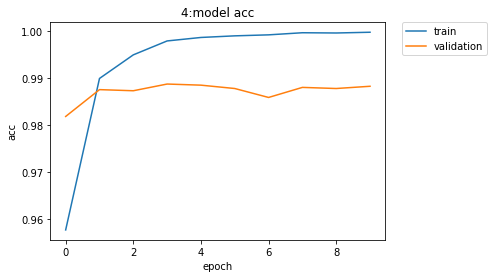

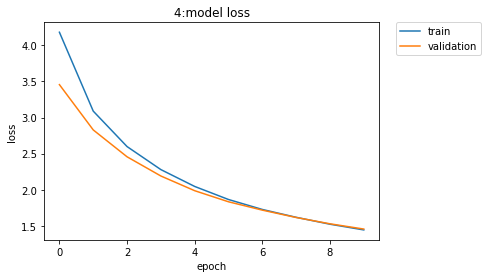

Done compiling best model.


4. Accuracy on validation data: 0.988336
Classification Report
              precision    recall  f1-score   support

           0    0.98565   0.99758   0.99158       413
           1    0.99147   0.99147   0.99147       469
           2    0.98807   0.99043   0.98925       418
           3    0.99302   0.98161   0.98728       435
           4    0.99017   0.99017   0.99017       407
           5    0.98688   0.98947   0.98817       380
           6    0.99034   0.99034   0.99034       414
           7    0.98194   0.98864   0.98528       440
           8    0.98759   0.98030   0.98393       406
           9    0.98801   0.98329   0.98565       419

   micro avg    0.98834   0.98834   0.98834      4201
   macro avg    0.98831   0.98833   0.98831      4201
weighted avg    0.98835   0.98834   0.98833      4201
 samples avg    0.98834   0.98834   0.98834      4201





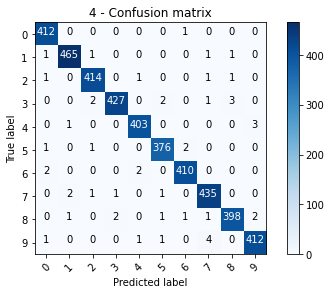

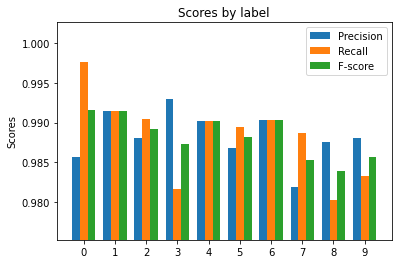

Iteration No. 5

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37792/37800 [============================>.] - ETA: 0s - loss: 4.2067 - acc: 0.9560- ETA: 0s - loss: 4.2126 - acc: 0
Epoch 00001: val_loss improved from inf to 3.48844, saving model to img_classifier_model_5_ResNet50_epoch10_batch32_ensemble.h5
37800/37800 [==============================] - 68s 2ms/sample - loss: 4.2065 - acc: 0.9560 - val_loss: 3.4884 - val_acc: 0.9831
Epoch 2/10
37760/37800 [============================>.] - ETA: 0s - loss: 3.1295 - acc: 0.9895- ETA: 1s - loss: 3.1346 - acc: - ETA: 0s - loss: 3.1314 - acc: 0.
Epoch 00002: val_loss improved from 3.48844 to 2.88545, saving model to img_classifier_model_5_ResNet50_epoch10_batch32_ensemble.h5
37800/37800 [==============================] - 59s 2ms/sample - loss: 3.1292 - acc: 0.9895 - val_loss: 2.8854 - val_acc: 0.9824
Epoch 3/10
37792/37800 [============================>.] - ETA: 0s - loss: 2.6423 - acc: 0.9957
Epoch 00003: val_loss improved fro

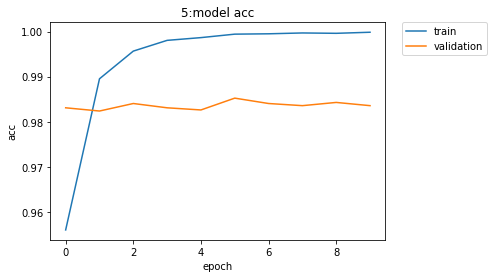

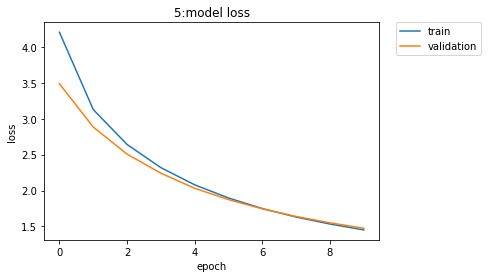

Done compiling best model.


5. Accuracy on validation data: 0.983571
Classification Report
              precision    recall  f1-score   support

           0    0.98804   1.00000   0.99398       413
           1    0.99568   0.98504   0.99033       468
           2    0.98565   0.98565   0.98565       418
           3    0.98165   0.98391   0.98278       435
           4    0.97789   0.97789   0.97789       407
           5    0.98677   0.98158   0.98417       380
           6    0.99034   0.99034   0.99034       414
           7    0.97333   0.99545   0.98427       440
           8    0.98500   0.97044   0.97767       406
           9    0.97115   0.96420   0.96766       419

   micro avg    0.98357   0.98357   0.98357      4200
   macro avg    0.98355   0.98345   0.98347      4200
weighted avg    0.98360   0.98357   0.98356      4200
 samples avg    0.98357   0.98357   0.98357      4200





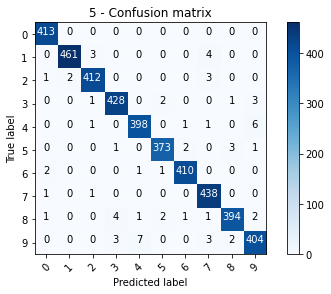

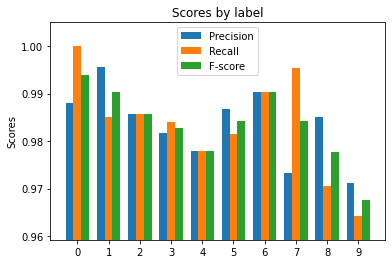

Iteration No. 6

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37760/37801 [============================>.] - ETA: 0s - loss: 4.2153 - acc: 0.9556
Epoch 00001: val_loss improved from inf to 3.49340, saving model to img_classifier_model_6_ResNet50_epoch10_batch32_ensemble.h5
37801/37801 [==============================] - 68s 2ms/sample - loss: 4.2145 - acc: 0.9556 - val_loss: 3.4934 - val_acc: 0.9817
Epoch 2/10
37792/37801 [============================>.] - ETA: 0s - loss: 3.1339 - acc: 0.9899- ETA: 1s - loss: 
Epoch 00002: val_loss improved from 3.49340 to 2.87676, saving model to img_classifier_model_6_ResNet50_epoch10_batch32_ensemble.h5
37801/37801 [==============================] - 59s 2ms/sample - loss: 3.1341 - acc: 0.9899 - val_loss: 2.8768 - val_acc: 0.9869
Epoch 3/10
37792/37801 [============================>.] - ETA: 0s - loss: 2.6521 - acc: 0.9957
Epoch 00003: val_loss improved from 2.87676 to 2.51535, saving model to img_classifier_model_6_ResNet50_epoch10_bat

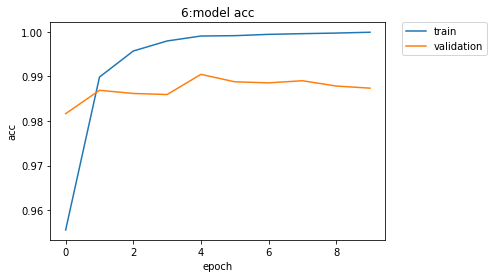

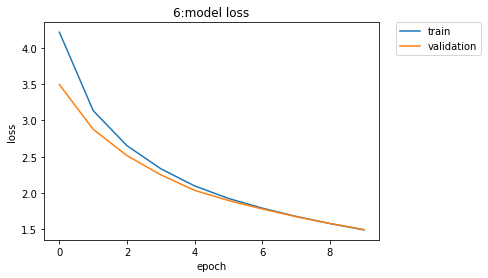

Done compiling best model.


6. Accuracy on validation data: 0.987378
Classification Report
              precision    recall  f1-score   support

           0    0.99275   0.99516   0.99395       413
           1    0.99147   0.99359   0.99253       468
           2    0.99041   0.98804   0.98922       418
           3    0.98169   0.98621   0.98394       435
           4    0.98284   0.98526   0.98405       407
           5    0.99730   0.97625   0.98667       379
           6    0.98565   0.99517   0.99038       414
           7    0.98646   0.99318   0.98981       440
           8    0.97304   0.97783   0.97543       406
           9    0.99275   0.98091   0.98679       419

   micro avg    0.98738   0.98738   0.98738      4199
   macro avg    0.98744   0.98716   0.98728      4199
weighted avg    0.98741   0.98738   0.98738      4199
 samples avg    0.98738   0.98738   0.98738      4199





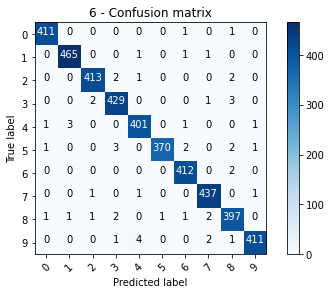

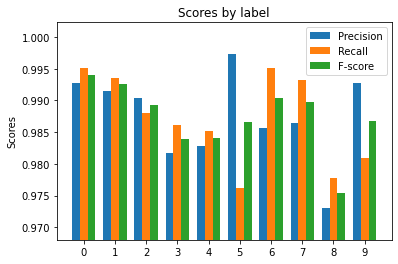

Iteration No. 7

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37760/37801 [============================>.] - ETA: 0s - loss: 4.1678 - acc: 0.9576- ETA
Epoch 00001: val_loss improved from inf to 3.42953, saving model to img_classifier_model_7_ResNet50_epoch10_batch32_ensemble.h5
37801/37801 [==============================] - 67s 2ms/sample - loss: 4.1670 - acc: 0.9577 - val_loss: 3.4295 - val_acc: 0.9819
Epoch 2/10
37792/37801 [============================>.] - ETA: 0s - loss: 3.0733 - acc: 0.9903
Epoch 00002: val_loss improved from 3.42953 to 2.81145, saving model to img_classifier_model_7_ResNet50_epoch10_batch32_ensemble.h5
37801/37801 [==============================] - 59s 2ms/sample - loss: 3.0733 - acc: 0.9903 - val_loss: 2.8114 - val_acc: 0.9857
Epoch 3/10
37792/37801 [============================>.] - ETA: 0s - loss: 2.5882 - acc: 0.9951- ETA: 2s -
Epoch 00003: val_loss improved from 2.81145 to 2.44454, saving model to img_classifier_model_7_ResNet50_epoch10_batch

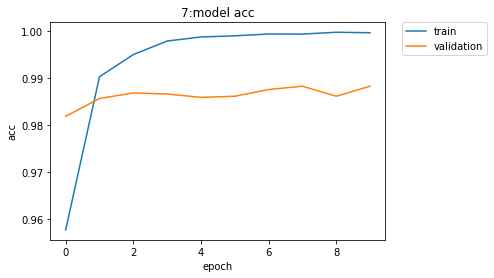

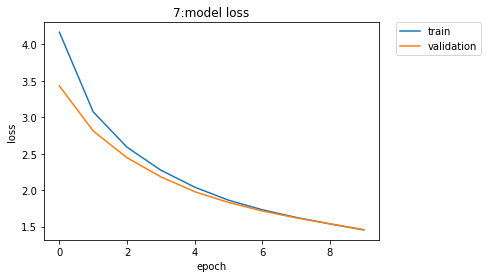

Done compiling best model.


7. Accuracy on validation data: 0.988331
Classification Report
              precision    recall  f1-score   support

           0    0.98795   0.99274   0.99034       413
           1    0.99572   0.99359   0.99465       468
           2    0.98786   0.97368   0.98072       418
           3    1.00000   0.98161   0.99072       435
           4    0.98775   0.99017   0.98896       407
           5    0.98163   0.98681   0.98421       379
           6    0.99034   0.99034   0.99034       414
           7    0.98430   0.99773   0.99097       440
           8    0.98289   0.99015   0.98650       406
           9    0.98333   0.98568   0.98451       419

   micro avg    0.98833   0.98833   0.98833      4199
   macro avg    0.98818   0.98825   0.98819      4199
weighted avg    0.98837   0.98833   0.98833      4199
 samples avg    0.98833   0.98833   0.98833      4199





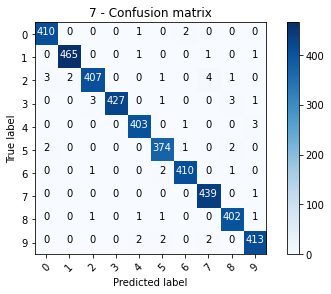

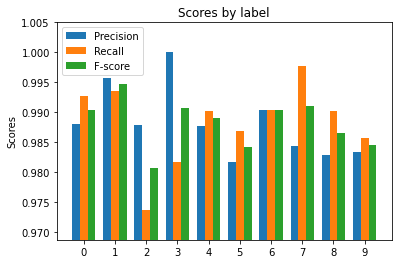

Iteration No. 8

Train on 37803 samples, validate on 4197 samples
Epoch 1/10
37792/37803 [============================>.] - ETA: 0s - loss: 4.2214 - acc: 0.9538
Epoch 00001: val_loss improved from inf to 3.50271, saving model to img_classifier_model_8_ResNet50_epoch10_batch32_ensemble.h5
37803/37803 [==============================] - 68s 2ms/sample - loss: 4.2212 - acc: 0.9538 - val_loss: 3.5027 - val_acc: 0.9807
Epoch 2/10
37792/37803 [============================>.] - ETA: 0s - loss: 3.1417 - acc: 0.9896- ETA: 4s - loss: 3.1616 - acc: 0
Epoch 00002: val_loss improved from 3.50271 to 2.87723, saving model to img_classifier_model_8_ResNet50_epoch10_batch32_ensemble.h5
37803/37803 [==============================] - 59s 2ms/sample - loss: 3.1418 - acc: 0.9896 - val_loss: 2.8772 - val_acc: 0.9869
Epoch 3/10
37792/37803 [============================>.] - ETA: 0s - loss: 2.6585 - acc: 0.9951- ETA: 2s 
Epoch 00003: val_loss improved from 2.87723 to 2.50944, saving model to img_classifier_mod

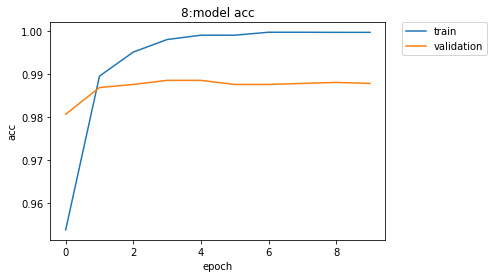

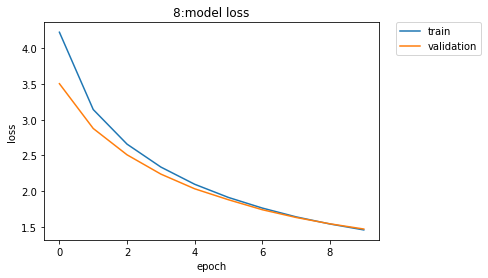

Done compiling best model.


8. Accuracy on validation data: 0.987848
Classification Report
              precision    recall  f1-score   support

           0    0.98568   1.00000   0.99279       413
           1    0.99151   0.99786   0.99468       468
           2    0.99281   0.99281   0.99281       417
           3    0.99072   0.98161   0.98614       435
           4    0.98529   0.98771   0.98650       407
           5    0.98425   0.98945   0.98684       379
           6    0.99756   0.98789   0.99270       413
           7    0.98639   0.98864   0.98751       440
           8    0.98272   0.98030   0.98150       406
           9    0.98072   0.97136   0.97602       419

   micro avg    0.98785   0.98785   0.98785      4197
   macro avg    0.98776   0.98776   0.98775      4197
weighted avg    0.98786   0.98785   0.98784      4197
 samples avg    0.98785   0.98785   0.98785      4197





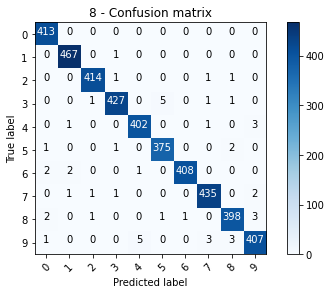

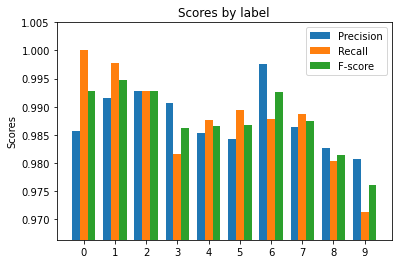

Iteration No. 9

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37792/37804 [============================>.] - ETA: 0s - loss: 4.1568 - acc: 0.9581
Epoch 00001: val_loss improved from inf to 3.41341, saving model to img_classifier_model_9_ResNet50_epoch10_batch32_ensemble.h5
37804/37804 [==============================] - 68s 2ms/sample - loss: 4.1566 - acc: 0.9581 - val_loss: 3.4134 - val_acc: 0.9852
Epoch 2/10
37792/37804 [============================>.] - ETA: 0s - loss: 3.0601 - acc: 0.9902
Epoch 00002: val_loss improved from 3.41341 to 2.79644, saving model to img_classifier_model_9_ResNet50_epoch10_batch32_ensemble.h5
37804/37804 [==============================] - 59s 2ms/sample - loss: 3.0600 - acc: 0.9902 - val_loss: 2.7964 - val_acc: 0.9883
Epoch 3/10
37792/37804 [============================>.] - ETA: 0s - loss: 2.5709 - acc: 0.9962
Epoch 00003: val_loss improved from 2.79644 to 2.42388, saving model to img_classifier_model_9_ResNet50_epoch10_batch32_ensemble.h5
3

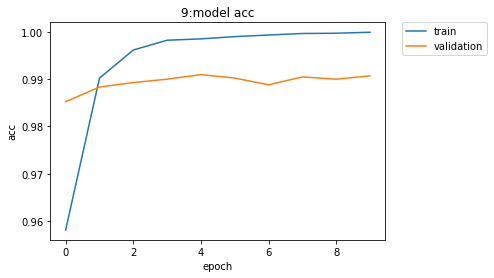

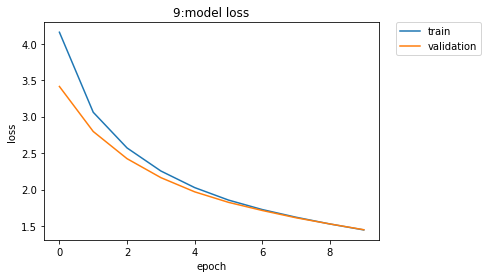

Done compiling best model.


9. Accuracy on validation data: 0.990705
Classification Report
              precision    recall  f1-score   support

           0    0.99041   1.00000   0.99518       413
           1    0.99153   1.00000   0.99574       468
           2    0.99036   0.98561   0.98798       417
           3    0.99766   0.98161   0.98957       435
           4    0.98780   0.99509   0.99143       407
           5    0.98956   1.00000   0.99475       379
           6    1.00000   0.99031   0.99513       413
           7    0.99317   0.99091   0.99204       440
           8    0.97810   0.99015   0.98409       406
           9    0.98786   0.97368   0.98072       418

   micro avg    0.99071   0.99071   0.99071      4196
   macro avg    0.99065   0.99074   0.99066      4196
weighted avg    0.99074   0.99071   0.99070      4196
 samples avg    0.99071   0.99071   0.99071      4196





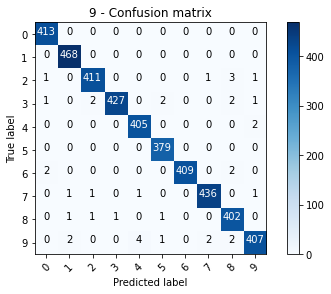

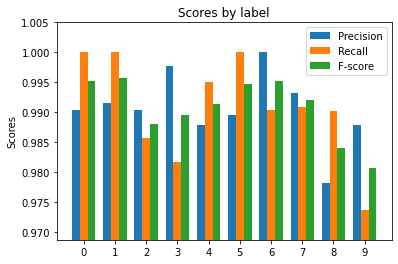

Iteration No. 10

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37792/37804 [============================>.] - ETA: 0s - loss: 4.1327 - acc: 0.9585
Epoch 00001: val_loss improved from inf to 3.39620, saving model to img_classifier_model_10_ResNet50_epoch10_batch32_ensemble.h5
37804/37804 [==============================] - 68s 2ms/sample - loss: 4.1325 - acc: 0.9584 - val_loss: 3.3962 - val_acc: 0.9819
Epoch 2/10
37760/37804 [============================>.] - ETA: 0s - loss: 3.0409 - acc: 0.989 - ETA: 0s - loss: 3.0404 - acc: 0.9894
Epoch 00002: val_loss improved from 3.39620 to 2.78544, saving model to img_classifier_model_10_ResNet50_epoch10_batch32_ensemble.h5
37804/37804 [==============================] - 60s 2ms/sample - loss: 3.0401 - acc: 0.9893 - val_loss: 2.7854 - val_acc: 0.9874
Epoch 3/10
37760/37804 [============================>.] - ETA: 0s - loss: 2.5668 - acc: 0.9951
Epoch 00003: val_loss improved from 2.78544 to 2.43009, saving model to img_classifier_model

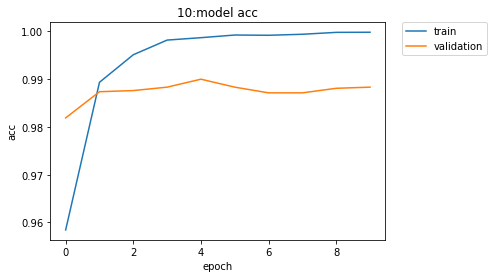

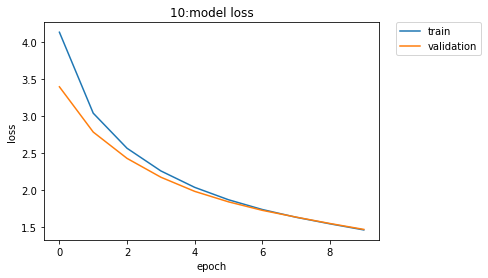

Done compiling best model.


10. Accuracy on validation data: 0.988322
Classification Report
              precision    recall  f1-score   support

           0    0.99034   0.99274   0.99154       413
           1    0.99356   0.98932   0.99143       468
           2    0.98341   0.99520   0.98927       417
           3    0.98843   0.98161   0.98501       435
           4    0.98526   0.98526   0.98526       407
           5    0.98433   0.99472   0.98950       379
           6    0.99275   0.99516   0.99395       413
           7    0.98630   0.98182   0.98405       440
           8    0.99751   0.98522   0.99133       406
           9    0.98091   0.98325   0.98208       418

   micro avg    0.98832   0.98832   0.98832      4196
   macro avg    0.98828   0.98843   0.98834      4196
weighted avg    0.98834   0.98832   0.98832      4196
 samples avg    0.98832   0.98832   0.98832      4196





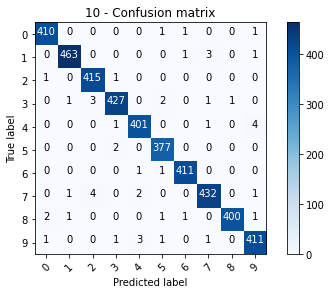

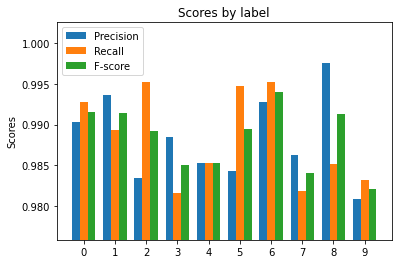

In [6]:
# ラベルの分布比率を維持した無作為抽出で10分割の交差検証を行う．シードは0で固定
skf = StratifiedKFold(n_splits=sp, shuffle = True, random_state = 0) 

for i, (train_idx, val_idx) in enumerate(skf.split(train, label_num)):
    # train(90%) / validation(10%) に分割
    X_train = train[train_idx]
    Y_train = label[train_idx]
    X_val = train[val_idx]
    Y_val = label[val_idx]
    
    # 分割ごとにモデルを初期化
    momentum = Adam(lr=learning_rate, decay=0.01)
    ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50
    ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

    # 学習を開始
    print("Iteration No. %d\n" %(i+1))
    
    # モデル読み込み時に使用するファイル
    model_file = 'img_classifier_model_%s_%s.h5' %(i+1, model_name)
    
    # 学習時に使用するコールバック
    def model_callbacks():
        # 各エポックでval_lossを監視し，最小値を更新した場合にモデルの重みを保存
        checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        # early_stopping_patience回連続でval_loss下がらなければ，学習打ち止め
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')

        return [checkpoint, early_stopping]

    callbacks_list = model_callbacks()
    
    # モデルのフィッティング
    history = ResNetModel.fit(X_train, 
                              Y_train, 
                              batch_size=batch_size, 
                              epochs=n_epoch,
                              verbose=1,
                              shuffle=True,
                              validation_data=(X_val, Y_val),
                              callbacks=callbacks_list)
    
    # 学習曲線の可視化
    def visualise_curve(model, monitor, itr):
        plt.figure()
        plt.plot(model.history[monitor])
        # validationも可視化する場合
        if isinstance(itr, int):
            plt.plot(model.history["val_"+ monitor])
        plt.title(str(itr)+":model "+ monitor)
        plt.ylabel(monitor)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
        plt.savefig(csv_dir+"/"+str(itr)+" - "+monitor+".png", bbox_inches="tight")
        plt.show()
            
    visualise_curve(history, "acc", i+1) # accuracyに関して表示
    visualise_curve(history, "loss", i+1) # lossに関して表示
    
    # 最良のモデルでvalidationデータの性能評価
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    plt.close("all")
    print("Done compiling best model.\n\n")
    
    # validationデータの予測
    predict[val_idx] = loaded_model.predict(X_val) # 各ラベルである確率
    predict_label[val_idx] = np_utils.to_categorical(np.argmax(predict[val_idx], axis=1), n_classes) # one-hot encoding
    
    # accuracyの表示
    print("%d. Accuracy on validation data: %f" %(i+1, accuracy_score(Y_val, predict_label[val_idx])))
    acc_str = str(i+1)+". Accuracy on validation data: "+ str(accuracy_score(Y_val, predict_label[val_idx]))+"\n\n"
    acc_list[i] = accuracy_score(Y_val, predict_label[val_idx])

    # その他の評価指標の表示と結果の保存
    print("Classification Report")
    report = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5)+"\n\n"
    report_file=open(csv_dir + "/report_" + model_name + ".txt","a")
    report_file.write(acc_str + report)
    report_file.close()
    print(report)
    other_score = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5, output_dict=True)
    
    for j in range(n_classes):
        precision_list[i,j] = other_score[str(j)]["precision"]
        recall_list[i,j] = other_score[str(j)]["recall"]
        fscore_list[i,j] = other_score[str(j)]["f1-score"]
        
    avg_precision[i] = other_score["macro avg"]["precision"]
    avg_recall[i] = other_score["macro avg"]["recall"]
    avg_fscore[i] = other_score["macro avg"]["f1-score"]

    # 混合行列の計算
    np.set_printoptions(precision=2)
    cnf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(predict[val_idx], axis=1))

    # 混合行列の描画と保存
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize: # パーセント表記にしたい場合
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            filename = title + "_normalized.png"
        else: # 実際のデータ数で表示したい場合
            filename = title + "_nonnorm.png"

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(conf_dir + "/" + filename, bbox_inches="tight")
        plt.show()

    plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title=str(i+1)+" - Confusion matrix")
    
    # 各ラベルの精度に関してグラフ化
    def plot_scores(precision, recall, fscore, title):
        x = np.arange(len(class_names)) * 2 # ラベルの位置
        width = 0.5 # バーの横幅

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width, precision, width, label="Precision")
        rects2 = ax.bar(x, recall, width, label="Recall")
        rects3 = ax.bar(x + width, fscore, width, label="F-score")
        ylim_min = np.min([precision, recall, fscore]) - 0.005
        ylim_max = np.max([precision, recall, fscore]) + 0.005

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Scores by label')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names)
        ax.set_ylim(ylim_min, ylim_max)
        ax.legend()

        plt.savefig(csv_dir + "/" + title)
        plt.show()
    
    plot_scores(precision_list[i], recall_list[i], fscore_list[i], title = str(i+1)+ " - Score.png")
    
    # 各交差検証の終わりに不要なデータを破棄
    clear_session()
    del ResNetModel, loaded_model, history, X_train, X_val, Y_train, Y_val
    gc.collect()
    
#clear_output()

# move h5 file
if "ensemble" in model_name:
    for i in glob.glob("*model*"+model_name+"*"+"h5"):
        shutil.move(i, model_dir)

# モデルファイルの削除
for i in glob.glob("*"+model_name+"*"):
    os.remove(i)

### 4.2.2 Total Results Report

Accuracy on all validarion data: 0.987619
Classification Report
              precision    recall  f1-score   support

           0    0.99037   0.99564   0.99300      4132
           1    0.99423   0.99295   0.99359      4684
           2    0.98708   0.98731   0.98719      4177
           3    0.98960   0.98460   0.98710      4351
           4    0.98386   0.98821   0.98603      4072
           5    0.98630   0.98682   0.98656      3795
           6    0.99153   0.99057   0.99105      4137
           7    0.98576   0.99068   0.98821      4401
           8    0.98421   0.98154   0.98287      4063
           9    0.98224   0.97708   0.97965      4188

   micro avg    0.98762   0.98762   0.98762     42000
   macro avg    0.98752   0.98754   0.98753     42000
weighted avg    0.98762   0.98762   0.98762     42000
 samples avg    0.98762   0.98762   0.98762     42000





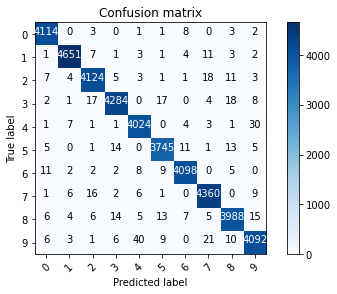

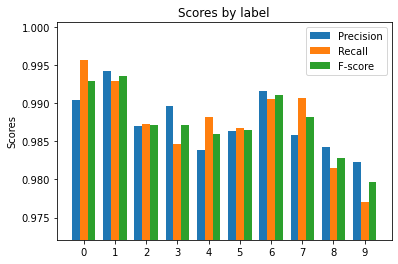

In [7]:
# 交差検証の結果の集計
plt.close('all')

# accuracyの表示
print('Accuracy on all validarion data: %f' %accuracy_score(label, predict_label))
acc_str = "Accuracy on all validarion data: "+ str(accuracy_score(label, predict_label))+"\n\n"

print('Classification Report')
report = classification_report(label, predict_label, target_names = class_names, digits = 5)+"\n\n"
report_file=open(csv_dir+"/report_"+ model_name + ".txt","a")
report_file.write(acc_str + report)
report_file.close()
print(report)

# 混合行列の計算
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(predict_label, axis=1))

# 混合行列の描画と保存
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title='Confusion matrix')

# 各交差検証の評価値を集計
score_table = pd.DataFrame(index = list(range(1,sp+1)))
score_table["Accuracy"] = acc_list
score_table["avg_Precision"] = avg_precision
score_table["avg_Recall"] = avg_recall
score_table["avg_F-score"] = avg_fscore

for i in range(n_classes):
    score_table[str(i) + "_Precision"] = precision_list[:, i]
    score_table[str(i) + "_Recall"] = recall_list[:, i]    
    score_table[str(i) + "_F-score"] = fscore_list[:, i]    
    
# 平均と標準偏差を計算して追加
avg = pd.Series(score_table.mean(),name="Avg")
std = pd.Series(score_table.std(),name="Std")

# 資料等に乗せるために整形したものも追加　(平均精度を % 表記，括弧内に標準偏差)
sr = []
for col in score_table.columns:
    sr.append(str(round(avg[col]*100,1))+"("+str(round(std[col]*100,1))+")%")
    
sr = pd.Series(sr, index=score_table.columns, name="sr")

# 追加データを結合
score_table = score_table.append(avg)
score_table = score_table.append(std)
score_table = score_table.append(sr)

# 結果ファイルを出力
score_table.to_csv(csv_dir+"/Result_"+model_name+".csv")

# 各ラベルの精度に関してグラフ化
plot_scores(avg[4:35:3], avg[5:35:3], avg[6:35:3], title = "Score.png")

### 4.2.3 Error data results

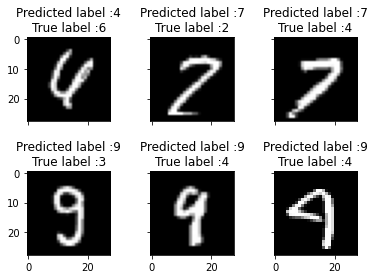

In [8]:
# 間違って推測したラベルの予測値と正しいラベルの予測値の差が大きいデータを上位6枚表示
predict_label_num = np.argmax(predict, axis=1) # 予測されたクラス名
errors = (predict_label_num - label_num != 0) # 間違ったデータはTrue

pred_classes_errors = predict_label_num[errors] # エラーデータの予測されたクラス名を抽出
pred_errors = predict[errors] # エラーデータの各クラスの予測値
true_errors = label_num[errors] # エラーデータの正しいクラス名
val_errors = train[errors] # エラーデータ（画像）

# 予測ラベルと正解ラベルを表記して，エラーデータを表示する関数
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    # 余白を設定
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.savefig(csv_dir + "/" + "Error.png")

# エラーデータが間違って予測されたクラスの予測値を抽出
pred_errors_prob = np.max(pred_errors,axis = 1)

# エラーデータの正しいクラスの予測値を抽出
true_prob_errors = np.diagonal(np.take(pred_errors, true_errors, axis=1))

# 予測されたクラスと正しいクラスの予測値の差
delta_pred_true_errors = pred_errors_prob - true_prob_errors

# delta_pred_true_errorsを小さい順にソートした時のインデックスを抽出
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 正解ラベルとの予測値の差が大きいデータのインデックスを上位6個抽出
most_important_errors = sorted_dela_errors[-6:]

# 表示
display_errors(most_important_errors, val_errors, pred_classes_errors, true_errors)

# 5. All data training and test

## 5.1 Training

Train on 42000 samples
Epoch 1/10
42000/42000 [==============================] - 71s 2ms/sample - loss: 4.1129 - acc: 0.9595
Epoch 2/10
42000/42000 [==============================] - 63s 1ms/sample - loss: 3.0078 - acc: 0.9901
Epoch 3/10
42000/42000 [==============================] - 63s 2ms/sample - loss: 2.5224 - acc: 0.9954
Epoch 4/10
42000/42000 [==============================] - 63s 2ms/sample - loss: 2.2102 - acc: 0.997910s - - ETA: 8s - loss: 2 - ETA: 
Epoch 5/10
42000/42000 [==============================] - 63s 2ms/sample - loss: 1.9871 - acc: 0.9986
Epoch 6/10
42000/42000 [==============================] - 63s 2ms/sample - loss: 1.8205 - acc: 0.9992
Epoch 7/10
42000/42000 [==============================] - 63s 2ms/sample - loss: 1.6883 - acc: 0.9994: 1s - loss: 1.6894
Epoch 8/10
42000/42000 [==============================] - 63s 2ms/sample - loss: 1.5823 - acc: 0.99962s
Epoch 9/10
42000/42000 [==============================] - 63s 2ms/sample - loss: 1.4963 - acc: 0.9997
Epoch

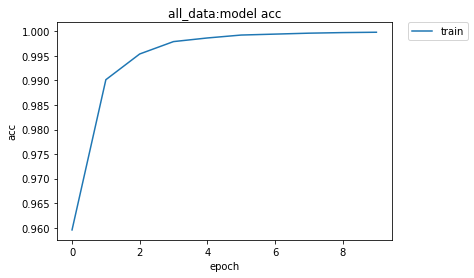

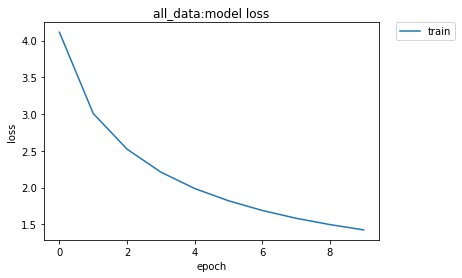

In [9]:
# モデルの初期化
momentum = Adam(lr=learning_rate, decay=0.01)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes)
ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

# モデルのフィッティング
history = ResNetModel.fit(train, label, batch_size=batch_size, epochs=n_epoch, verbose=1, shuffle=True)

# 学習曲線の可視化
visualise_curve(history, "acc", "all_data") # accuracyに関して表示
visualise_curve(history, "loss", "all_data") # lossに関して表示

## 5.2 Test

In [10]:
# testデータの予測
test_predict = ResNetModel.predict(test) # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result1.csv", index = False)

# モデルの破棄
clear_session()
del ResNetModel, history
gc.collect()

514797

# 6. Ensemble model test

In [11]:
# 各バリデーションモデルの予測値の平均
test_predict = np.zeros((len(test), n_classes))
for model_file in glob.glob(model_dir+"/*"):
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    test_predict += loaded_model.predict(test)
    # モデルの破棄
    clear_session()
    del loaded_model
    gc.collect()

test_predict /= n_classes # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result2.csv", index = False)